In [1]:
from vocabulary_functions import load_tokenizers
import sqlite3
import pandas as pd
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)
df_uniprot_human_seqs = pd.read_sql(f"SELECT Sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref50_distilled)", conn)
conn.close()
print(len(df_uniprot_human_seqs))
corpus = df_uniprot_human_seqs["Sequence"]

70901


In [4]:
# Connect to DB
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

uniref_id = '50'
df_protein = pd.read_sql(f"""SELECT Entry as uniprot_id, Sequence as sequence
                          FROM proteins
                          WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)""", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_interpro_domain = pd.read_sql(f"SELECT uniprot_id, interpro_id as source, start_index, end_index FROM interpro_entries_v2 WHERE type='domain'", conn)
df_ted = pd.read_sql(f"SELECT uniprot_id, ted_id as source, start_index, end_index FROM ted_entries_summary WHERE plddt >= 70", conn)

conn.close()

df_domains = pd.concat([df_interpro_domain, df_ted])
interpro_ids = df_domains.loc[df_domains["source"].str.startswith("IPR"), "uniprot_id"].unique() # Find uniprot_ids that have "interpro" as a source
df_domains = df_domains[~((df_domains["uniprot_id"].isin(interpro_ids)) & (df_domains["source"].str.startswith("AF")))] # Filter the DataFrame to exclude rows with source "ted" for those uniprot_ids
df_domains = df_protein.set_index('uniprot_id').join(df_domains.set_index('uniprot_id'), how='inner').reset_index()
df_domains['domain_sequence'] = df_domains.apply(lambda row: row['sequence'][row['start_index']-1: row['end_index']], axis=1)
df_domains = df_domains[df_domains['domain_sequence'].str.len()>0].reset_index(drop=True)
corpus = df_domains['domain_sequence']

In [3]:
# 'dataset': {'uniref50', 'uniref90'}
# 'is_pretokenizer': {True, False}
# 'subs_matrix': {'blosum45', 'blosum62', 'pam70', 'pam250'}
# 'mutation_cutoff': {0.7, 0.8, 0.9}
# 'min_mutation_freq': {0, 0.05,. 0.005}
# 'min_mutation_len': {3}
# 'max_mutation_len': {12}
# 'vocab_size': list=[800, 1600, 3200, 6400, 12800, 25600, 51200]

# vocab_sizes = [800, 1600, 3200, 6400, 12800]
vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600, 51200]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

In [4]:
tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

# vocab_list = {}
# for name, tokenizer in tokenizer_list.items():
#     vocab_list[name] = list(set([token for token, idx in tokenizer.get_vocab().items()]))

# list(tokenizer_list.keys()[0:5:])

In [14]:
import vocabulary_functions, random, statistics, math

def random_swap_experiment(name1, name2, corpus):
    tkz1 = tokenizer_list[name1]
    tkz2 = tokenizer_list[name2]

    voc1 = inner_vocab_list[name1]
    voc2 = inner_vocab_list[name2]

    families = vocabulary_functions.get_family_dictionary(voc2)

    segs1 = tkz1.encode_batch(corpus)
    segs2 = tkz2.encode_batch(corpus)
    swapped_sequences = []
    swap_indices = []
    for idx, (seg1, seg2) in enumerate(zip(segs1, segs2)):
        inters = set(seg1.offsets).intersection(seg2.offsets)
        if len(inters) > 0:
            # print(seg1.tokens)
            # print(seg2.tokens)
            swap_positions = {}
            for si, ei in inters:
                cur_tkn = corpus[idx][si:ei]
                if len(families[cur_tkn]) > 0:
                    family = families[cur_tkn]
                    suitable_relatives = []
                    for relative in family:
                        if relative != cur_tkn and relative in voc1:
                            suitable_relatives.append(relative)
                    order_differences = []
                    for relative in suitable_relatives:
                        order_differences.append(abs(voc1[relative]["order"] - voc2[relative]["order"]))
                    for i, diff in enumerate(order_differences):
                        if diff == min(order_differences):
                            swap_positions[(si, ei)] = (suitable_relatives[i], (si, ei))
                            break


            new_seq = corpus[idx]
            for k, (tkn, (si, ei)) in swap_positions.items():
                    new_seq = new_seq[:si] + tkn + new_seq[ei:]
            swapped_sequences.append(new_seq)
            swap_indices.append(idx)


    swapped_segs1 = tkz1.encode_batch(swapped_sequences)
    swapped_segs2 = tkz2.encode_batch(swapped_sequences)

    aggr1 = []
    aggr2 = []
    for idx, (seg1, seg2) in enumerate(zip(swapped_segs1, swapped_segs2)):
        aggr1.append(vocabulary_functions.calc_agreement(seg1.tokens, segs1[swap_indices[idx]].tokens))
        aggr2.append(vocabulary_functions.calc_agreement(seg2.tokens, segs2[swap_indices[idx]].tokens))
    agg1mean = statistics.mean(aggr1)
    agg2mean = statistics.mean(aggr2)
    agg1std = statistics.stdev(aggr1)
    agg2std = statistics.stdev(aggr2)
    return agg1mean, agg2mean, agg1std, agg2std



def single_swap_experiment(name, corpus):
    tkz = tokenizer_list[name]
    voc = inner_vocab_list[name]

    families = vocabulary_functions.get_family_dictionary(voc)

    segs = tkz.encode_batch(corpus)
    swapped_sequences = []
    swap_indices = []
    for idx, seg in enumerate(segs):
        swap_positions = {}
        for si, ei in seg.offsets:
            cur_tkn = corpus[idx][si:ei]
            if len(families[cur_tkn]) > 0:
                swap_positions[(si, ei)] = []
                family = families[cur_tkn]
                for relative in family:
                    if relative != cur_tkn:
                        swap_positions[(si, ei)].append((relative, (si, ei)))
        candidate_swaps = []
        for i in range(1):
            cur_candidate = []
            for k, v in swap_positions.items():
                # add the mutation if at least a swap is possible
                if len(v) > 0:
                    cur_candidate.append(random.choice(v))
            candidate_swaps.append(cur_candidate)
        for candidate in candidate_swaps:
            if len(candidate) == 0:
                continue
            new_seq = corpus[idx]
            for tkn, (si, ei) in candidate:
                new_seq = new_seq[:si] + tkn + new_seq[ei:]
            swapped_sequences.append(new_seq)
            swap_indices.append(idx)


    swapped_segs = tkz.encode_batch(swapped_sequences)

    aggr = []
    for idx, seg in enumerate(swapped_segs):
        aggr.append(vocabulary_functions.calc_agreement(seg.tokens, segs[swap_indices[idx]].tokens))
    aggmean = statistics.mean(aggr)
    aggstd = statistics.stdev(aggr)
    return aggmean, aggstd


Do the standard bpe swap experiment

In [15]:
import json
names = list(tokenizer_list.keys())
results = []
for i in range(7):
    print(f"experiment {i} starting")
    cur_names = names[i::7]
    cur_standard = cur_names[0]
    for mut_name in cur_names[1:]:
        print(f"starting {cur_standard} against {mut_name}")
        m1, m2, s1, s2 = random_swap_experiment(cur_standard, mut_name, corpus)
        print(f"finished {cur_standard} against {mut_name}, m1:{m1}, m2:{m2}, s1:{s1}, s2:{s2}")
        results.append((cur_standard, mut_name, m1, m2, s1, s2))
        with open("results_save.json", "w") as f:
            json.dump(results, f, indent=2)
    print(f"experiment {i} finished")
    

experiment 0 starting
starting stdBPE 800 against mutBPE blosum62 0.7 0.05 800
finished stdBPE 800 against mutBPE blosum62 0.7 0.05 800, m1:0.9901199107480908, m2:0.9938046932922074, s1:0.014885853224133822, s2:0.011472901460194739
starting stdBPE 800 against mutBPE pam70 0.7 0.05 800
finished stdBPE 800 against mutBPE pam70 0.7 0.05 800, m1:0.9856286127743077, m2:0.9898104614760194, s1:0.017909371311495212, s2:0.014507747783473045
starting stdBPE 800 against mutBPE pre blosum62 0.7 0.05 800
finished stdBPE 800 against mutBPE pre blosum62 0.7 0.05 800, m1:0.9895847957668935, m2:0.9924135859249631, s1:0.015259065619396219, s2:0.01267972752331041
starting stdBPE 800 against mutBPE pre pam70 0.7 0.05 800
finished stdBPE 800 against mutBPE pre pam70 0.7 0.05 800, m1:0.9871893050851687, m2:0.9895922089276962, s1:0.016803977110691752, s2:0.014446318059601768
experiment 0 finished
experiment 1 starting
starting stdBPE 1600 against mutBPE blosum62 0.7 0.05 1600
finished stdBPE 1600 against mut

Do the single vocab swap experiment

In [8]:
import json
names = list(tokenizer_list.keys())
names = [n for n in names if not n.startswith("stdBPE")]
results = []
for i in range(7):
    print(f"experiment {i} starting")
    cur_names = names[i::7]
    for mut_name in cur_names:
        print(f"starting {mut_name}")
        m, s = single_swap_experiment(mut_name, corpus)
        print(f"finished {mut_name}, m:{m}, s:{s}")
        results.append((mut_name, m, s))
        with open("results_save.json", "w") as f:
            json.dump(results, f, indent=2)
    print(f"experiment {i} finished")
    

experiment 0 starting
starting mutBPE blosum62 0.7 0.05 800
finished mutBPE blosum62 0.7 0.05 800, m:0.9714570197935871, s:0.03142062261066865
starting mutBPE pam70 0.7 0.05 800
finished mutBPE pam70 0.7 0.05 800, m:0.9691383738274987, s:0.03233246592243002
starting mutBPE pre blosum62 0.7 0.05 800
finished mutBPE pre blosum62 0.7 0.05 800, m:0.9728346183634846, s:0.030735706984525497
starting mutBPE pre pam70 0.7 0.05 800
finished mutBPE pre pam70 0.7 0.05 800, m:0.971178378412722, s:0.03150208069668484
experiment 0 finished
experiment 1 starting
starting mutBPE blosum62 0.7 0.05 1600
finished mutBPE blosum62 0.7 0.05 1600, m:0.9468957302998595, s:0.045394773899646475
starting mutBPE pam70 0.7 0.05 1600
finished mutBPE pam70 0.7 0.05 1600, m:0.9431328278604646, s:0.04709011898590852
starting mutBPE pre blosum62 0.7 0.05 1600
finished mutBPE pre blosum62 0.7 0.05 1600, m:0.9475578809773212, s:0.045609230275107736
starting mutBPE pre pam70 0.7 0.05 1600
finished mutBPE pre pam70 0.7 0.0

Generate graphs for comparison experiment

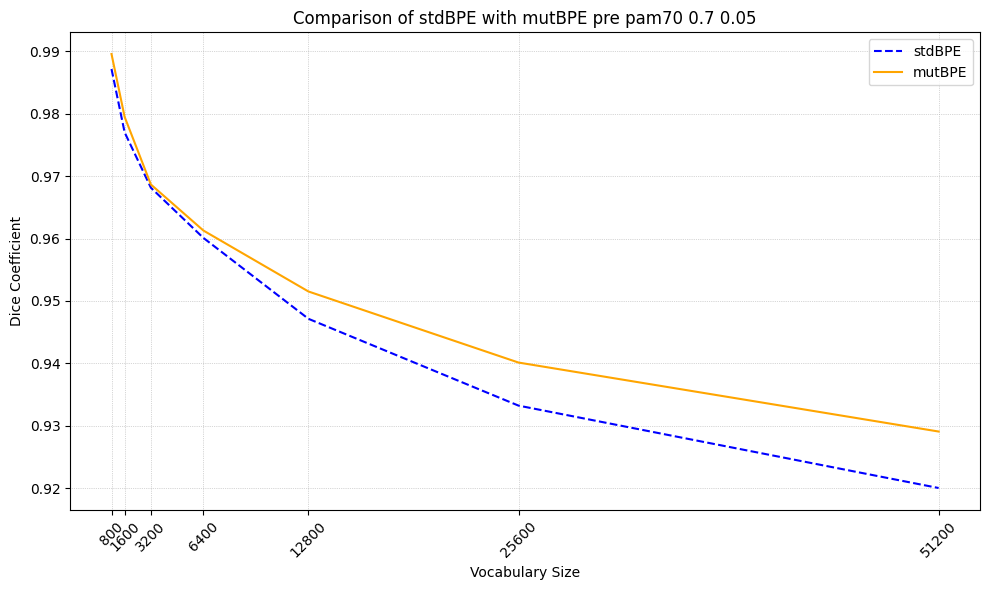

In [20]:
import json
import matplotlib.pyplot as plt
from matplotlib.table import Table

with open("results_save_uniref50v2.json") as f:
    results = json.load(f)

results = {(n1, n2): (m1,m2,s1,s2) for n1,n2,m1,m2,s1,s2 in results}

import matplotlib.pyplot as plt

# Define data
x = [800, 1600, 3200, 6400, 12800, 25600, 51200]

y_algo1 = []  
y_algo2 = [] 

algo2_prefix = "mutBPE pre pam70 0.7 0.05"

for val in x:
    m1, m2, s1, s2 = results[f"stdBPE {val}", f"{algo2_prefix} {val}"]
    y_algo1.append(m1)
    y_algo2.append(m2)
 



# Create the plot
plt.figure(figsize=(10, 6))

# Plot Algo1 with dashed lines
plt.plot(x, y_algo1, label="stdBPE", linestyle="--", color="blue")

# Plot Algo2 with solid lines
plt.plot(x, y_algo2, label="mutBPE", linestyle="-", color="orange")

# Customize X-axis
# plt.xscale("log")  # If desired, use a logarithmic scale for better spacing
plt.xticks(x, labels=[str(i) for i in x], rotation=45)  # Set custom X-axis labels

# Add labels and legend
plt.xlabel("Vocabulary Size")
plt.ylabel("Dice Coefficient")
plt.title(f"Comparison of stdBPE with {algo2_prefix}")
plt.legend()

# Display the plot
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()




Generate graphs for single swap experiment

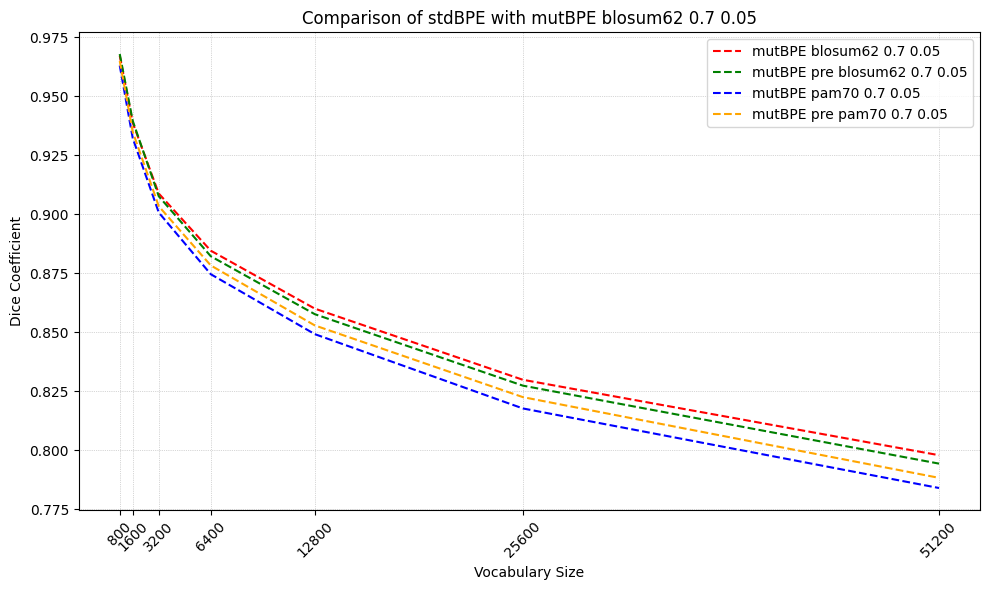

In [17]:
import json
import matplotlib.pyplot as plt
from matplotlib.table import Table

with open("results_save_single_uniref50.json") as f:
    results = json.load(f)

results = {n: (m, s) for n, m, s in results}

import matplotlib.pyplot as plt

# Define data
x = [800, 1600, 3200, 6400, 12800, 25600, 51200]

prefixes = [
    "mutBPE blosum62 0.7 0.05",
    "mutBPE pre blosum62 0.7 0.05",
    "mutBPE pam70 0.7 0.05",
    "mutBPE pre pam70 0.7 0.05",
]

y_dict = {}
for pre in prefixes:
    y_dict[pre] = []


algo2_prefix = "mutBPE blosum62 0.7 0.05"

for val in x:
    for pre in prefixes:
        m, s = results[pre + f" {val}"]
        y_dict[pre].append(m)
 



plt.figure(figsize=(10, 6))
plt.plot(x, y_dict[prefixes[0]], label=prefixes[0], linestyle="--", color="red")
plt.plot(x, y_dict[prefixes[1]], label=prefixes[1], linestyle="--", color="green")
plt.plot(x, y_dict[prefixes[2]], label=prefixes[2], linestyle="--", color="blue")
plt.plot(x, y_dict[prefixes[3]], label=prefixes[3], linestyle="--", color="orange")
# plt.xscale("log")  # If desired, use a logarithmic scale for better spacing
plt.xticks(x, labels=[str(i) for i in x], rotation=45)  # Set custom X-axis labels

# Add labels and legend
plt.xlabel("Vocabulary Size")
plt.ylabel("Dice Coefficient")
plt.title(f"Comparison of stdBPE with {algo2_prefix}")
plt.legend()

# Display the plot
plt.grid(True, which="both", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()


